In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks

### Opening MIP file

In [2]:
MIP_file = "./Run1_list.txt"

# The width of each column in the data text files
# Look at the txt file to find this information. The first column starts at 0 and ends at the last character
# The next column starts from there and goes until its last character
column_widths = [(0, 4), (4, 8), (8, 17), (17, 26), (26, 43), (43, 56), (56, 70)]

MIP_df = pd.read_fwf(MIP_file, colspecs=column_widths, skiprows=9, header=None, names=["Brd", "Ch", "LG", "HG", "Tstamp_us", "TrgID", "NHits"])
MIP_df["Tstamp_us"] = MIP_df["Tstamp_us"].fillna(method="ffill")
MIP_df["TrgID"] = MIP_df["TrgID"].fillna(method="ffill")
MIP_df["NHits"] = MIP_df["NHits"].fillna(method="ffill")

In [3]:
# Number of CAEN units = 6, each has 64 channels
CAEN_numbers = np.arange(6)
channel_numbers = np.arange(64)

### Opening the pedestal file
#### Should be organized "CAEN-Channel" in columns, "HG" and "LG" in rows, with each entry being a dictionary of {"m":mean value, "S
#### Don't yet have the pedestal information but we'll set up a placeheolder pedestal dataframe for now

In [ ]:
# pedestal_file_name = "pedestal.pkl"
# pedestal_df = pd.read_pickle(pedestal_file_name)  

In [4]:
pedestal_example = {}
for CAEN in CAEN_numbers:
    for channel in channel_numbers:
        column_name = f"{CAEN}-{channel}"
        HG_mean, HG_sigma = 0, 0
        LG_mean, LG_sigma = 0, 0
        channel_dict = {
            "HG":{"m":HG_mean, "s":HG_sigma},
            "LG":{"m":LG_mean, "s":LG_sigma}
        }
        pedestal_example[column_name] = channel_dict
pedestal_df = pd.DataFrame(pedestal_example)

In [5]:
pedestal_df

0-0               0-1               0-2               0-3  \
HG  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}   
LG  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}   

                 0-4               0-5               0-6               0-7  \
HG  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}   
LG  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}   

                 0-8               0-9  ...              5-54  \
HG  {'m': 0, 's': 0}  {'m': 0, 's': 0}  ...  {'m': 0, 's': 0}   
LG  {'m': 0, 's': 0}  {'m': 0, 's': 0}  ...  {'m': 0, 's': 0}   

                5-55              5-56              5-57              5-58  \
HG  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}   
LG  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}   

                5-59              5-60              5-61              5-62  \
HG  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}   
LG  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}  {'m': 0, 's': 0}   

                5-63  
HG  {'m': 0, 's': 0}  
LG  {'m': 0, 's': 0}  

[2 rows x 384 columns]

In [6]:
# Can access the entries as df["CAEN#-Channel#"]["HG"/"LG"]["m"/"s"] 
# HG = High gain, LG = low gain
# m = mean, s = sigm
pedestal_df["1-1"]["HG"]["m"]

0

### Defining a function to plot and fit the MIP data
### NOTE: THE FIT NEEDS TO BE ADJUSTED BASED ON THE ACTUAL MIP SIGNAL!

In [7]:
# Function to plot and fit the MIP data
# MIP_df is the pandas dataframe containing the MIP signal
# pedestal_df is the pandas dataframe containing the pedestal means and sigmas
# CAEN_number should be a specific number to select a specific CAEN unit
# channel_numbers is an array of possible channel_numbers for that CAEN unit
# gain_setting is which gain you want to select in the data -- either "HG" (high gain) or "LG" (low gain)
def plot_CAEN_MIPs(MIP_df, pedestal_df, CAEN_number, channel_numbers, gain_setting="HG"):
    if gain_setting != "HG" and gain_setting != "LG":
        raise ValueError(r'gain_setting must be "HG" (high gain) or "LG" (low gain)!')    
    num_columns, num_rows = 8, 8
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(30, 30), sharey=True, sharex=True)
    axes = axes.flatten()
    
    CAEN_mask = MIP_df["Brd"]==CAEN_number
    HG_MIPs = MIP_df[gain_setting][CAEN_mask]

    MIP_positions_dict = {}
    for channel in channel_numbers:
        # Selecting a specific channel in the dataframe
        channel_mask = MIP_df["Ch"][CAEN_mask]==channel
        HG_MIPs_for_channel = HG_MIPs[channel_mask]

        # Subtracting the pedestal mean from the MIP data and putting in a histogram
        pedestal_mean = pedestal_df[f"{CAEN_number}-{channel}"][gain_setting]["m"]
        pedestal_sigma = pedestal_df[f"{CAEN_number}-{channel}"][gain_setting]["s"]
        counts, bin_edges = np.histogram(HG_MIPs_for_channel - pedestal_mean, bins=50)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        errors = np.sqrt(counts)

        # Plotting the data
        axes[channel].scatter(bin_centers, counts)
        axes[channel].set_title(f"CAEN {CAEN_number}, Ch {channel}")
        axes[channel].set_xlabel("ADCs")

        # Interpolate the histogram data and drawing the interpolated curve
        if gain_setting == "LG":
            spline = UnivariateSpline(bin_centers, counts, s=20000, k=3)
        else:
            spline = UnivariateSpline(bin_centers, counts, s=100000, k=3)
            
        interp_x = np.linspace(bin_centers[0], bin_centers[-1], 1000)
        interp_y = spline(interp_x)
        axes[channel].plot(interp_x, interp_y, color='red')
        
        # Find peaks in the interpolated data
        peaks, _ = find_peaks(interp_y, height=0)
        
        # Identify the second peak near ~600, if it exists
        peak_positions = interp_x[peaks]
        second_peak_pos = 0
        for pos in peak_positions:
            if gain_setting == "LG":
                if 500 <= pos <= 1000:  # Look for a peak in this range
                    second_peak_pos = pos
                    break
            else:
                if 100 <= pos <= 200:
                    second_peak_pos = pos
                    break
        MIP_position = second_peak_pos
        
        # Saving the peak positions to a dictionary
        column_name = f"{CAEN_number}-{channel}"
        gain_MIP_dict = {f"{gain_setting}" : MIP_position}
        MIP_positions_dict[column_name] = gain_MIP_dict
    MIP_positions_df = pd.DataFrame(MIP_positions_dict)
    return MIP_positions_df

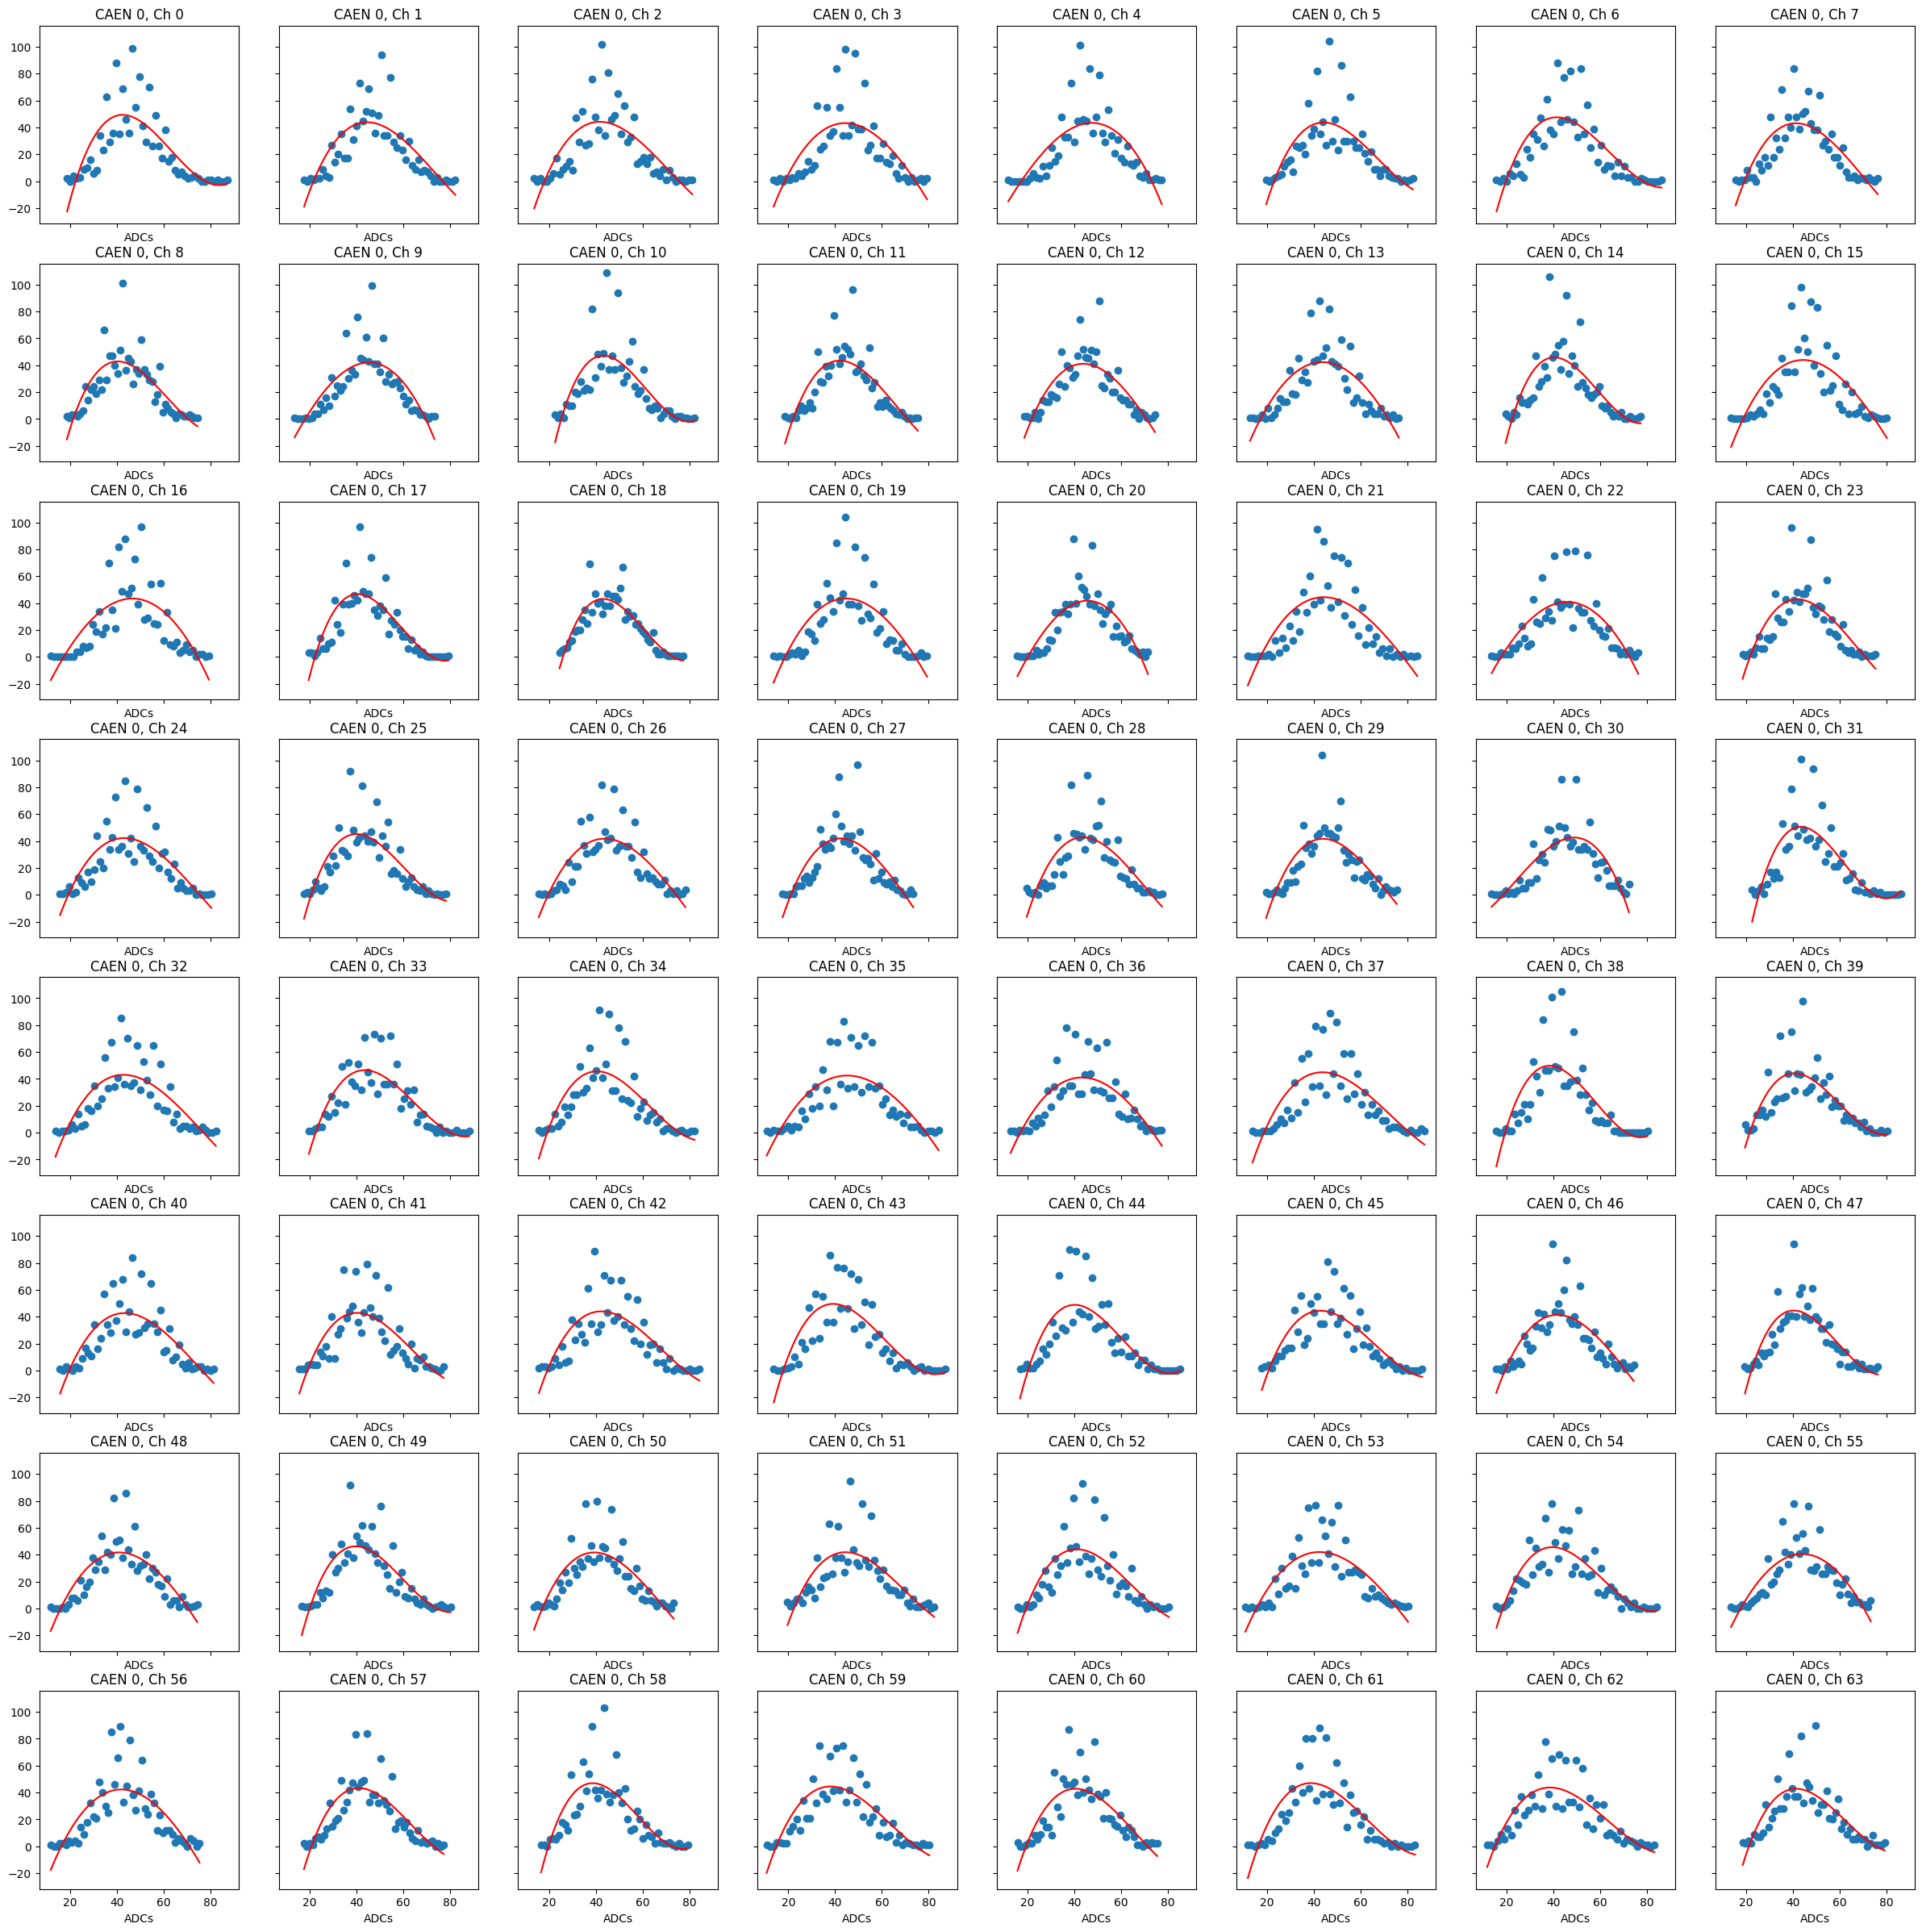

In [8]:
# Example: Getting the first CAEN units's MIP positions
CAEN_0_MIPs = plot_CAEN_MIPs(MIP_df, pedestal_df, 0, channel_numbers)

#### This is what the dataframe will look like for each CAEN unit

In [9]:
CAEN_0_MIPs

0-0  0-1  0-2  0-3  0-4  0-5  0-6  0-7  0-8  0-9  ...  0-54  0-55  0-56  \
HG    0    0    0    0    0    0    0    0    0    0  ...     0     0     0   

    0-57  0-58  0-59  0-60  0-61  0-62  0-63  
HG     0     0     0     0     0     0     0  

[1 rows x 64 columns]

#### Plotting and fitting all CAEN units

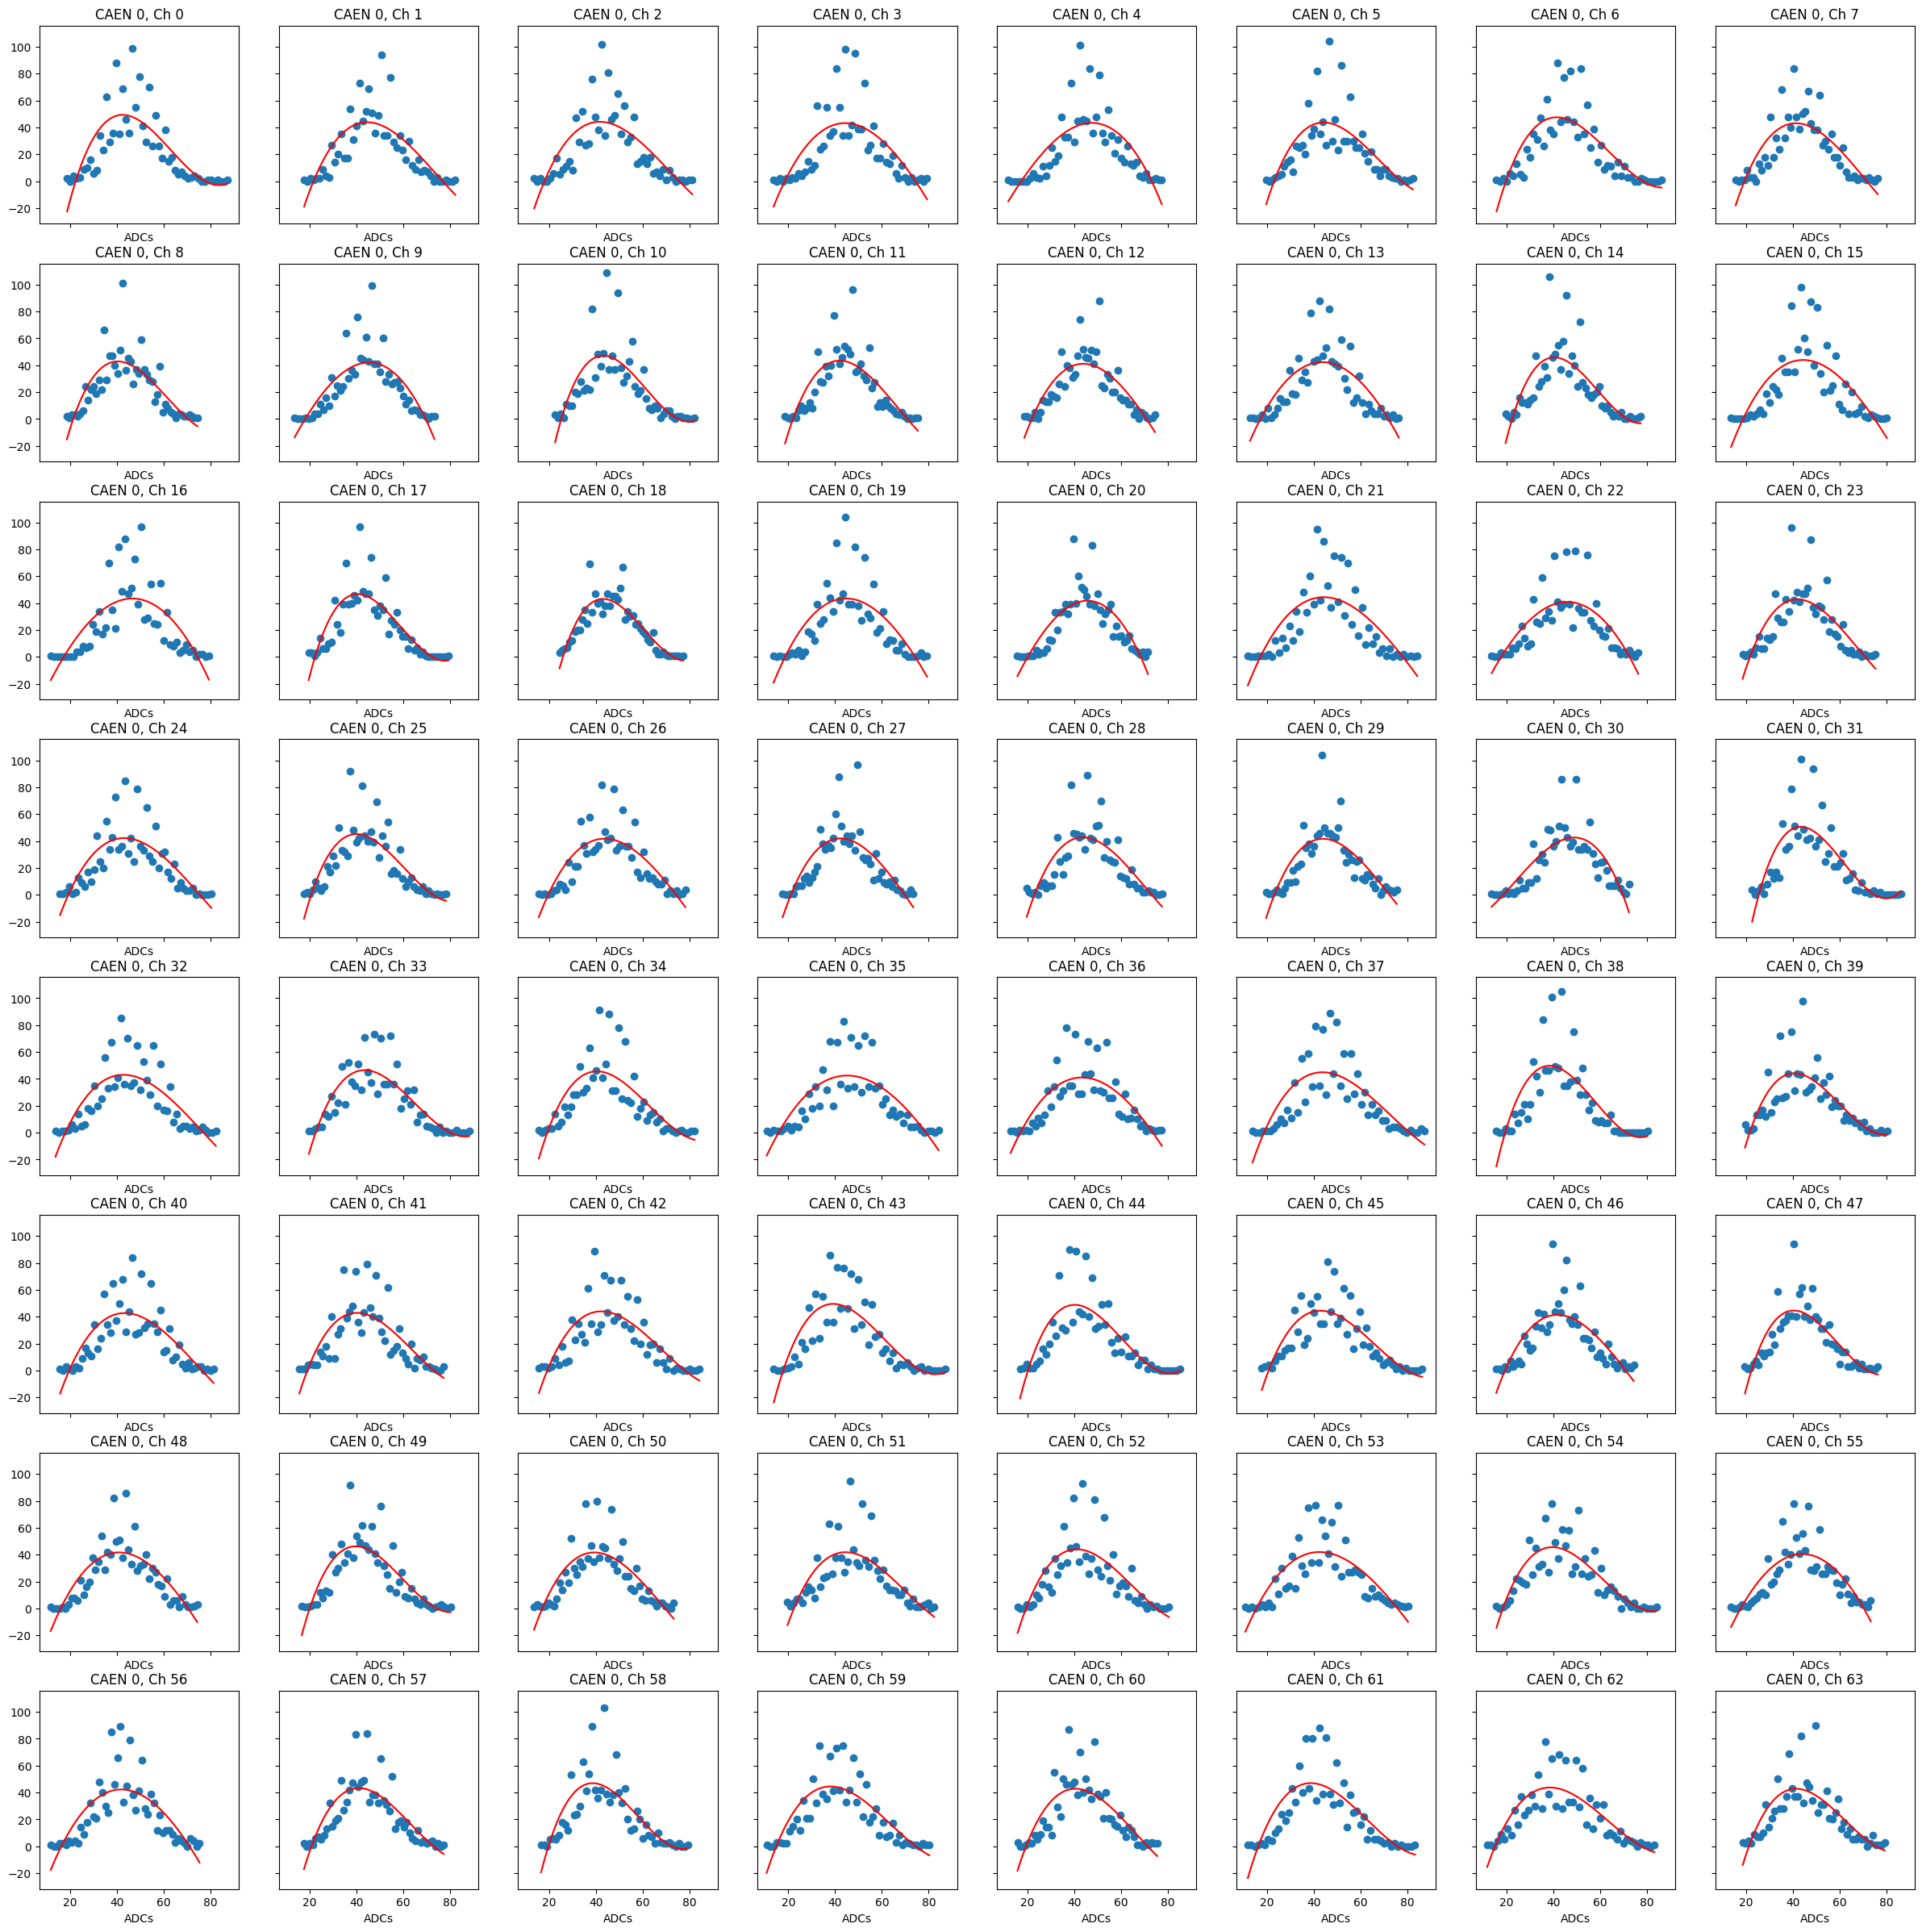

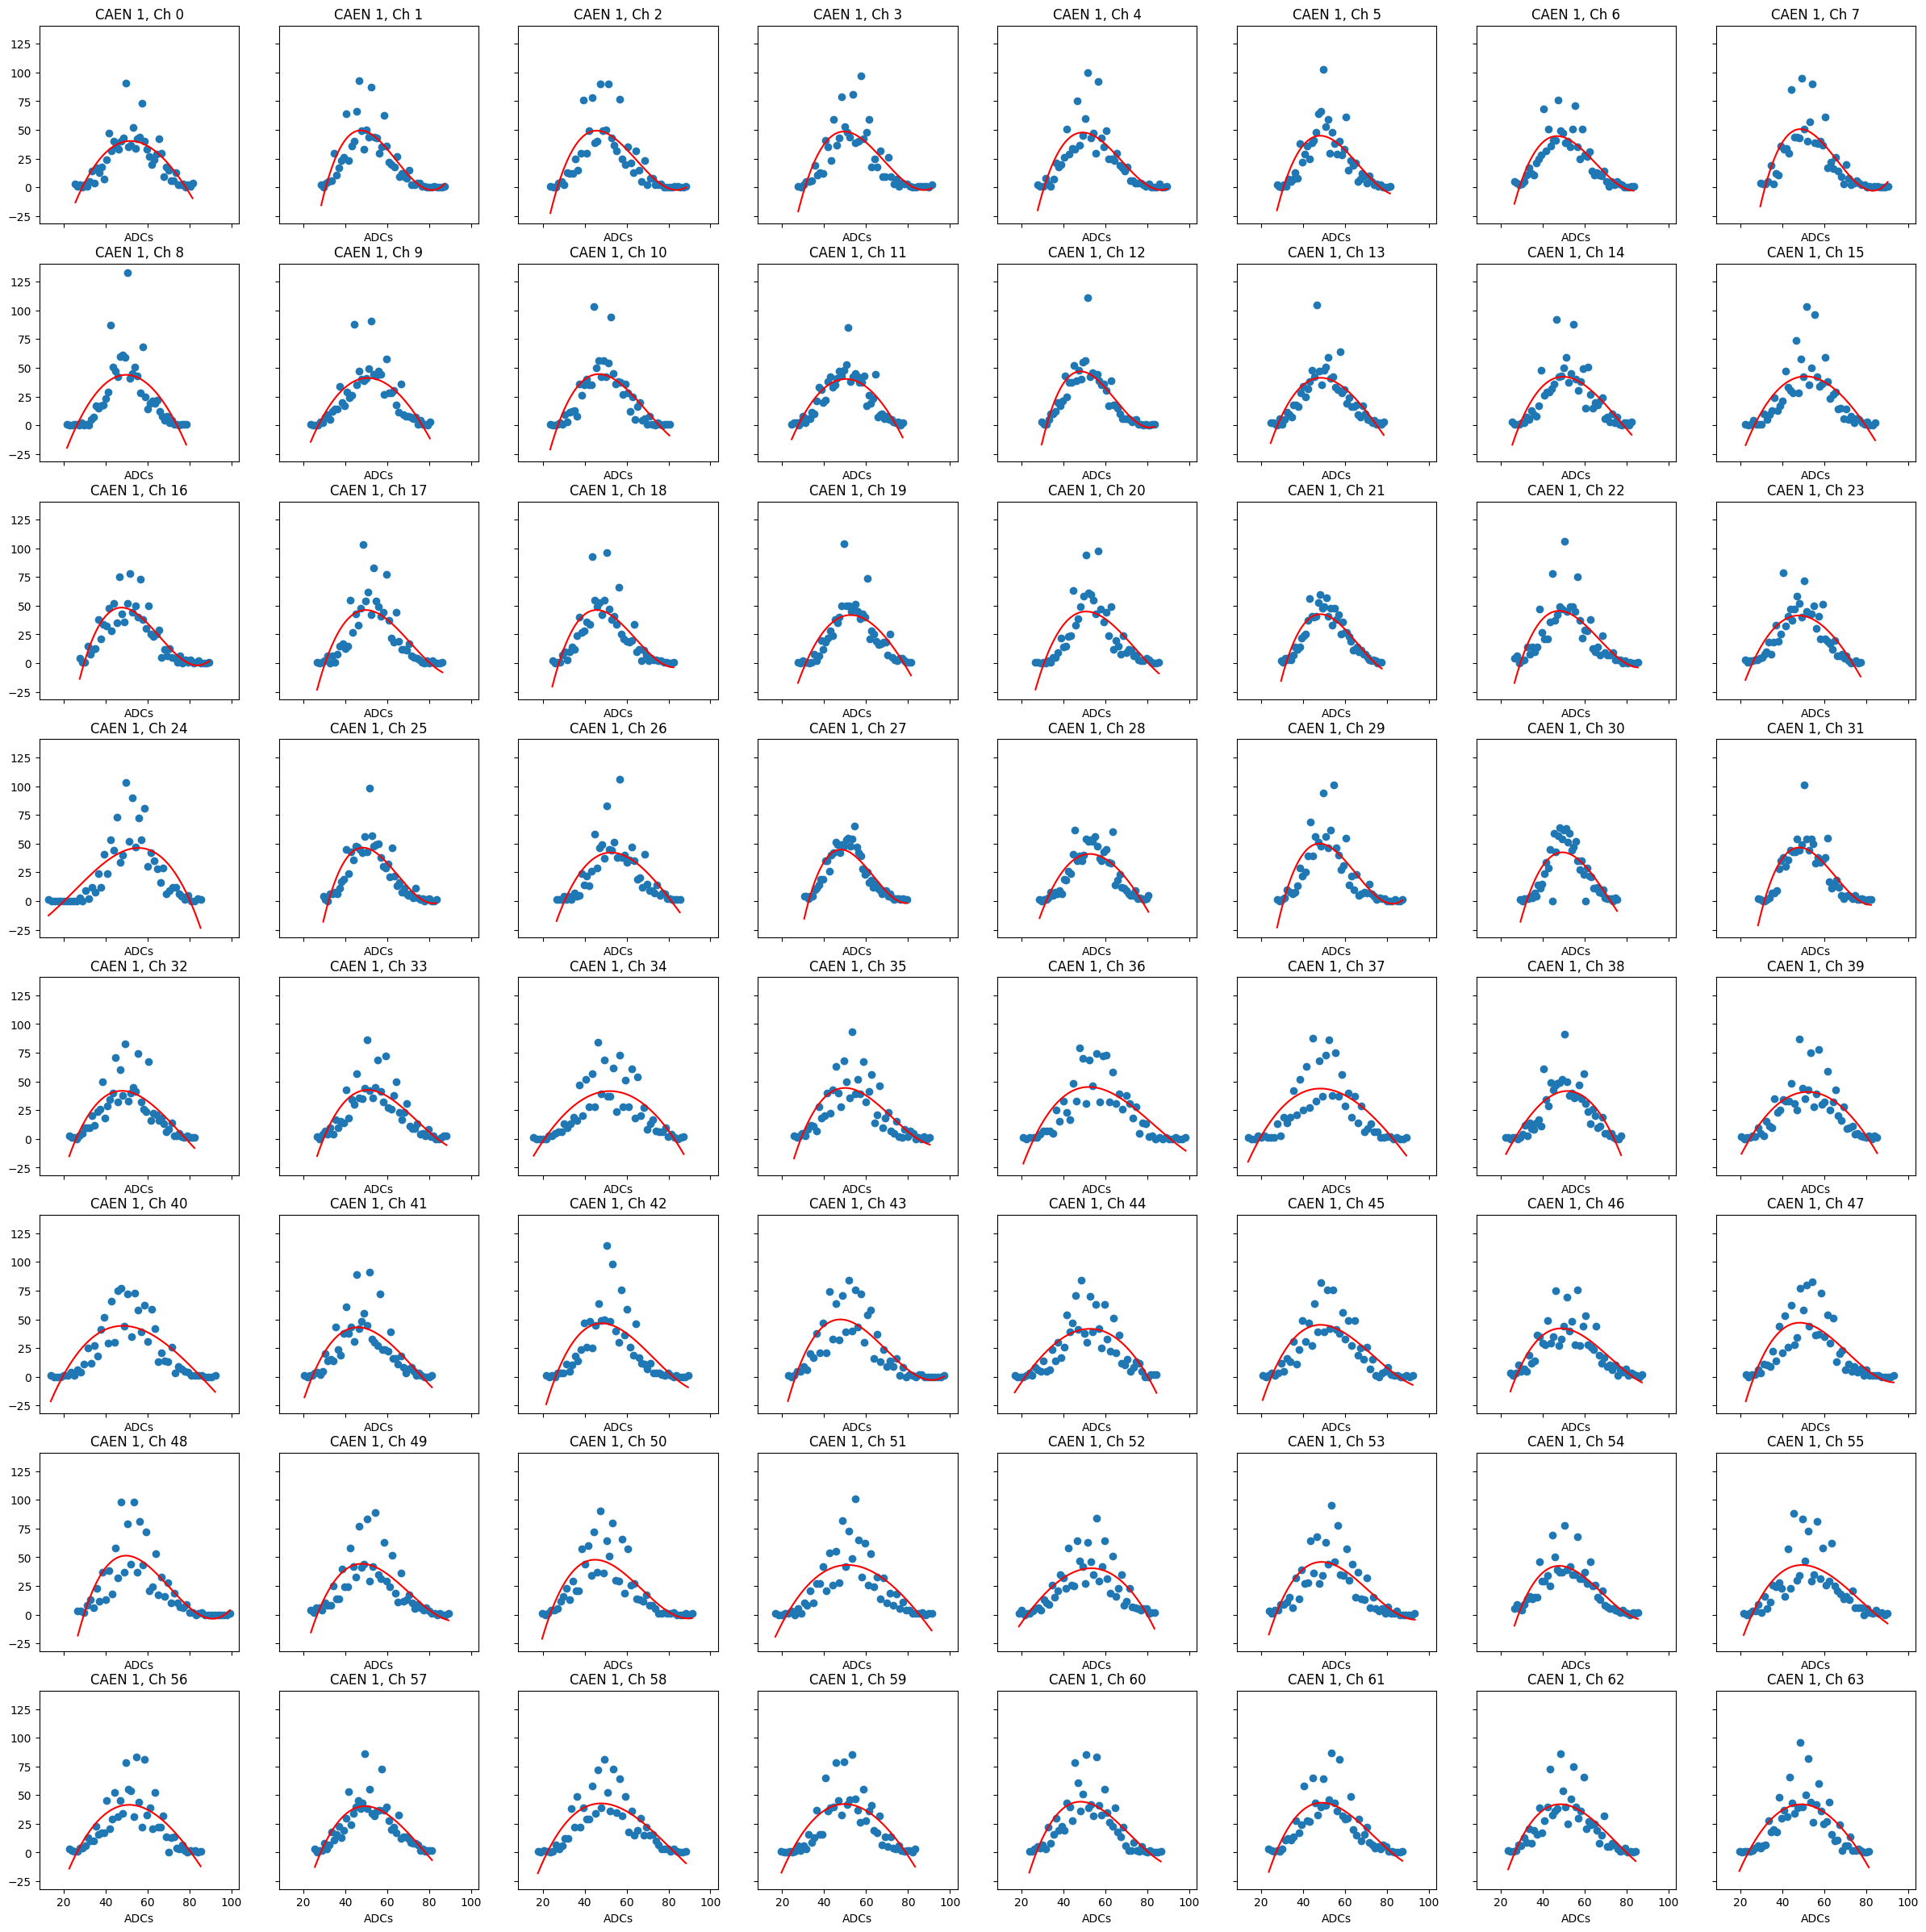

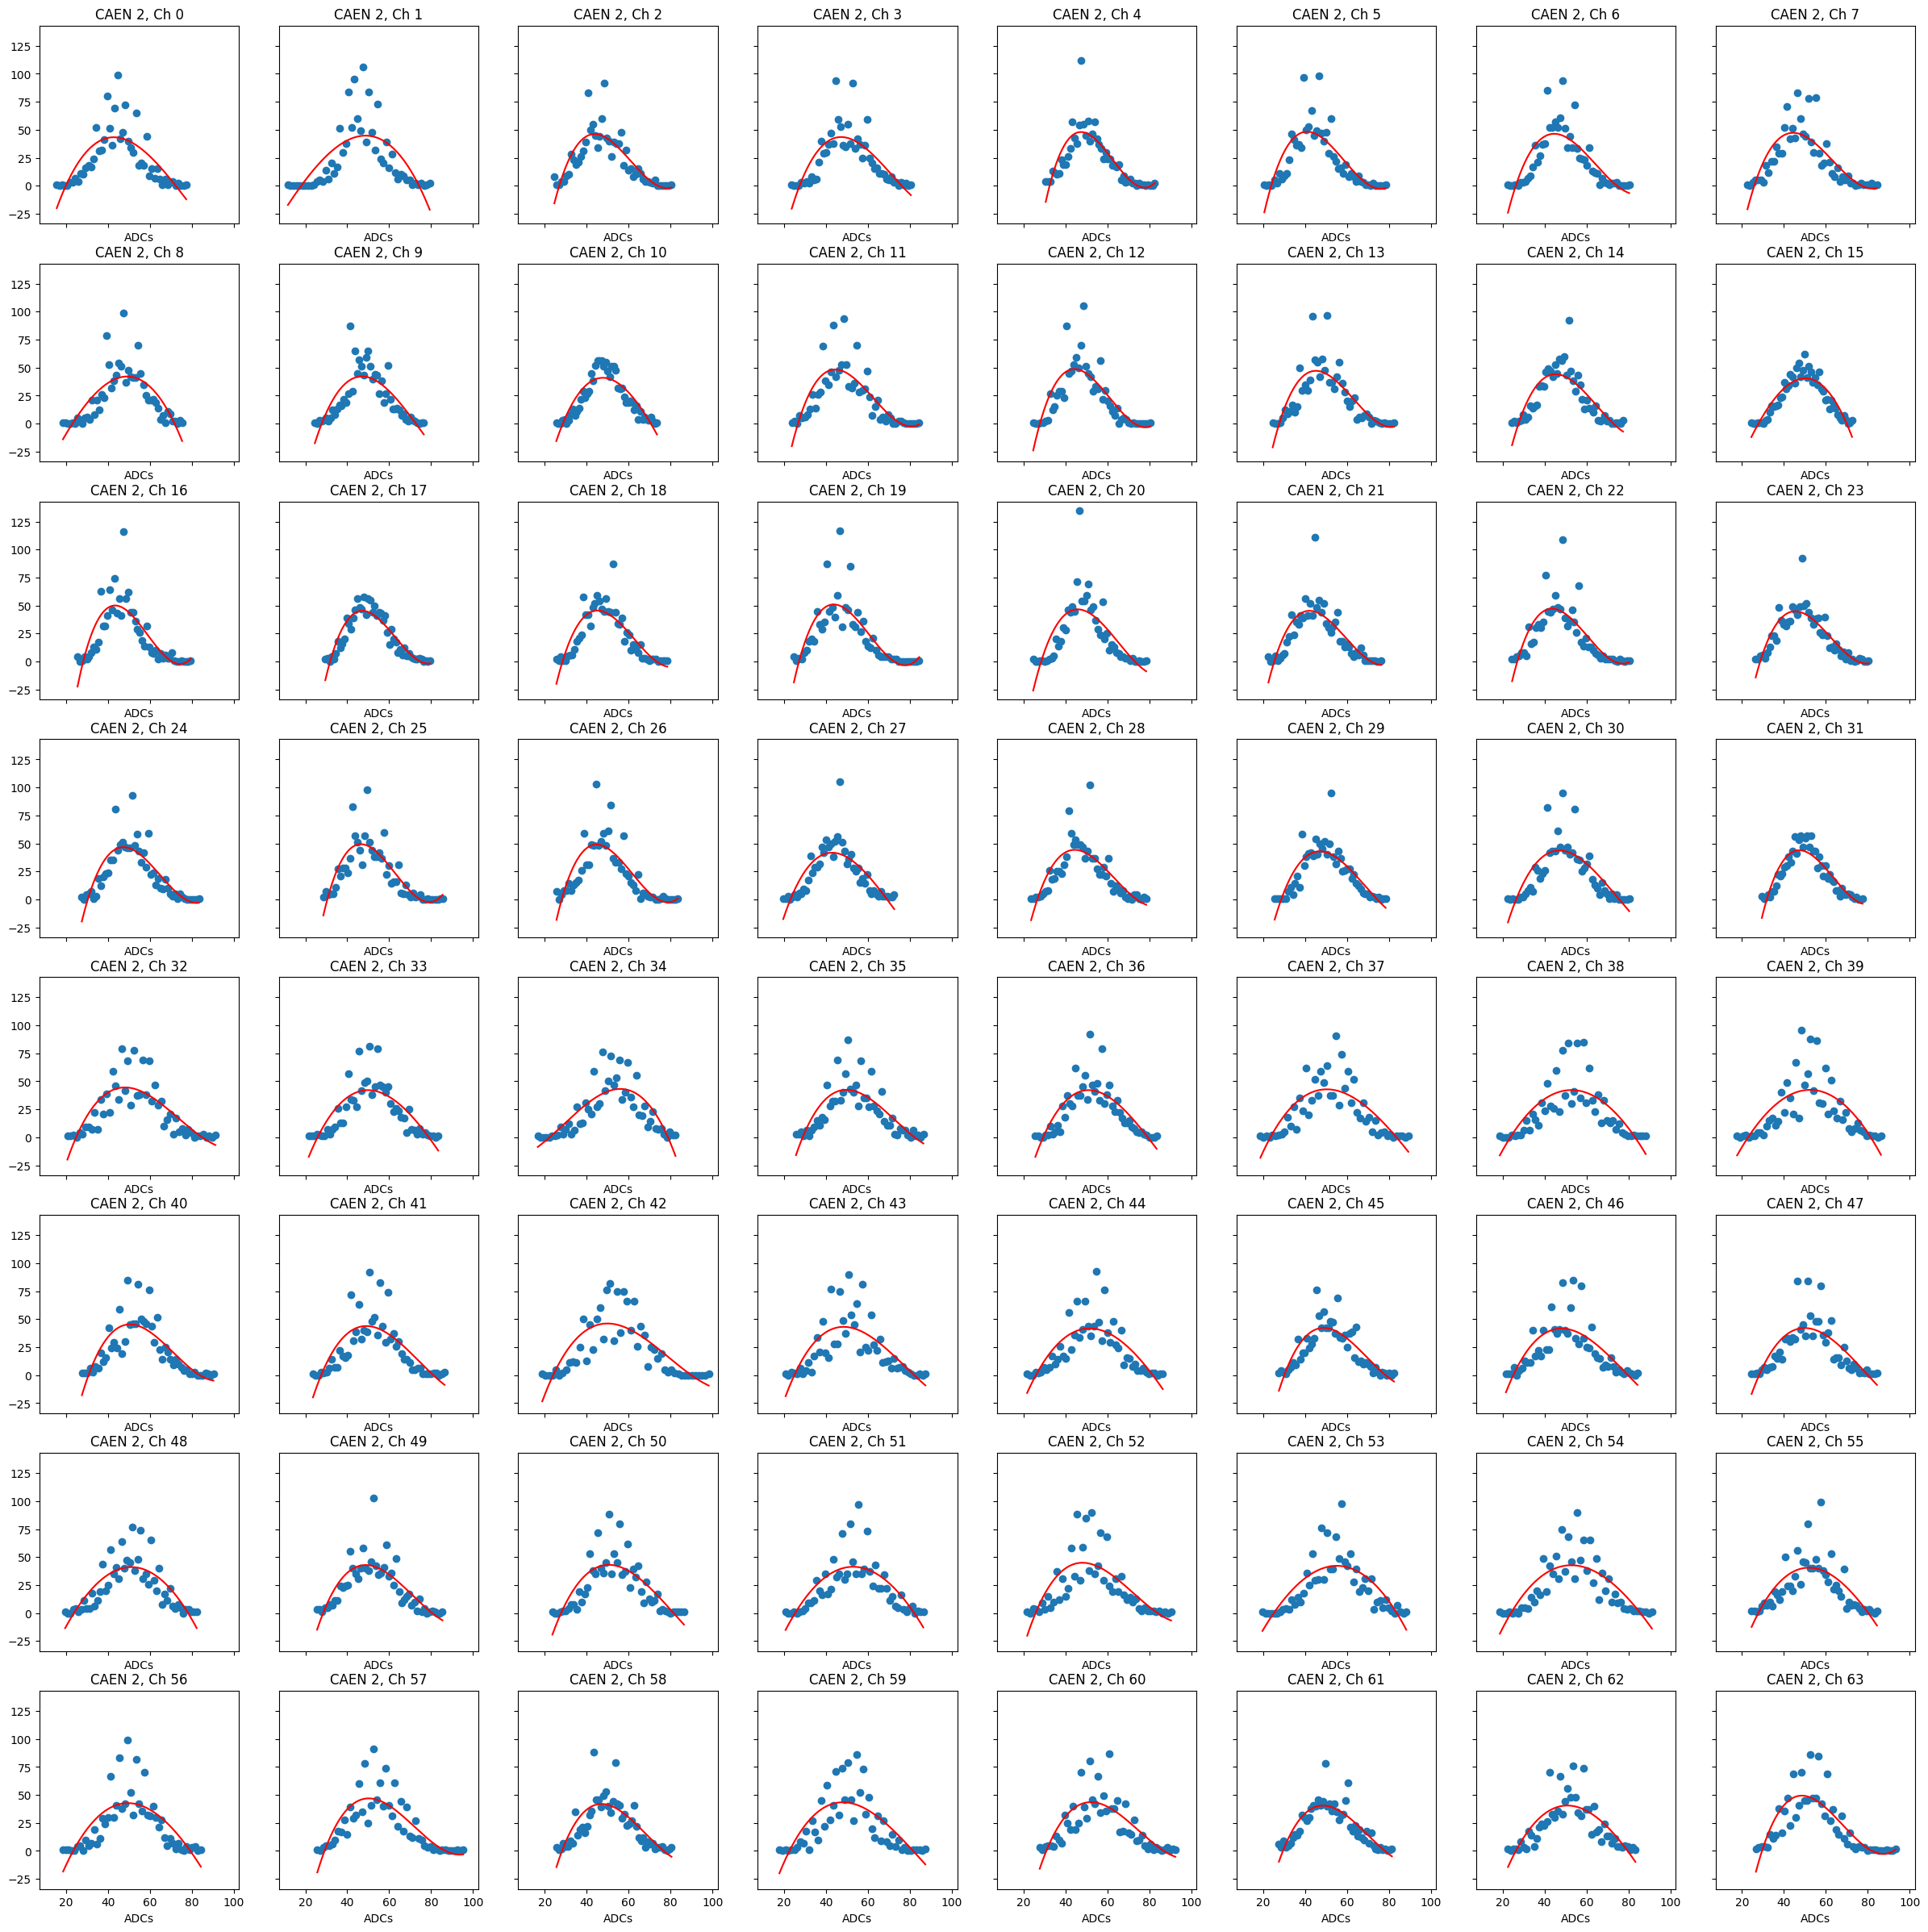

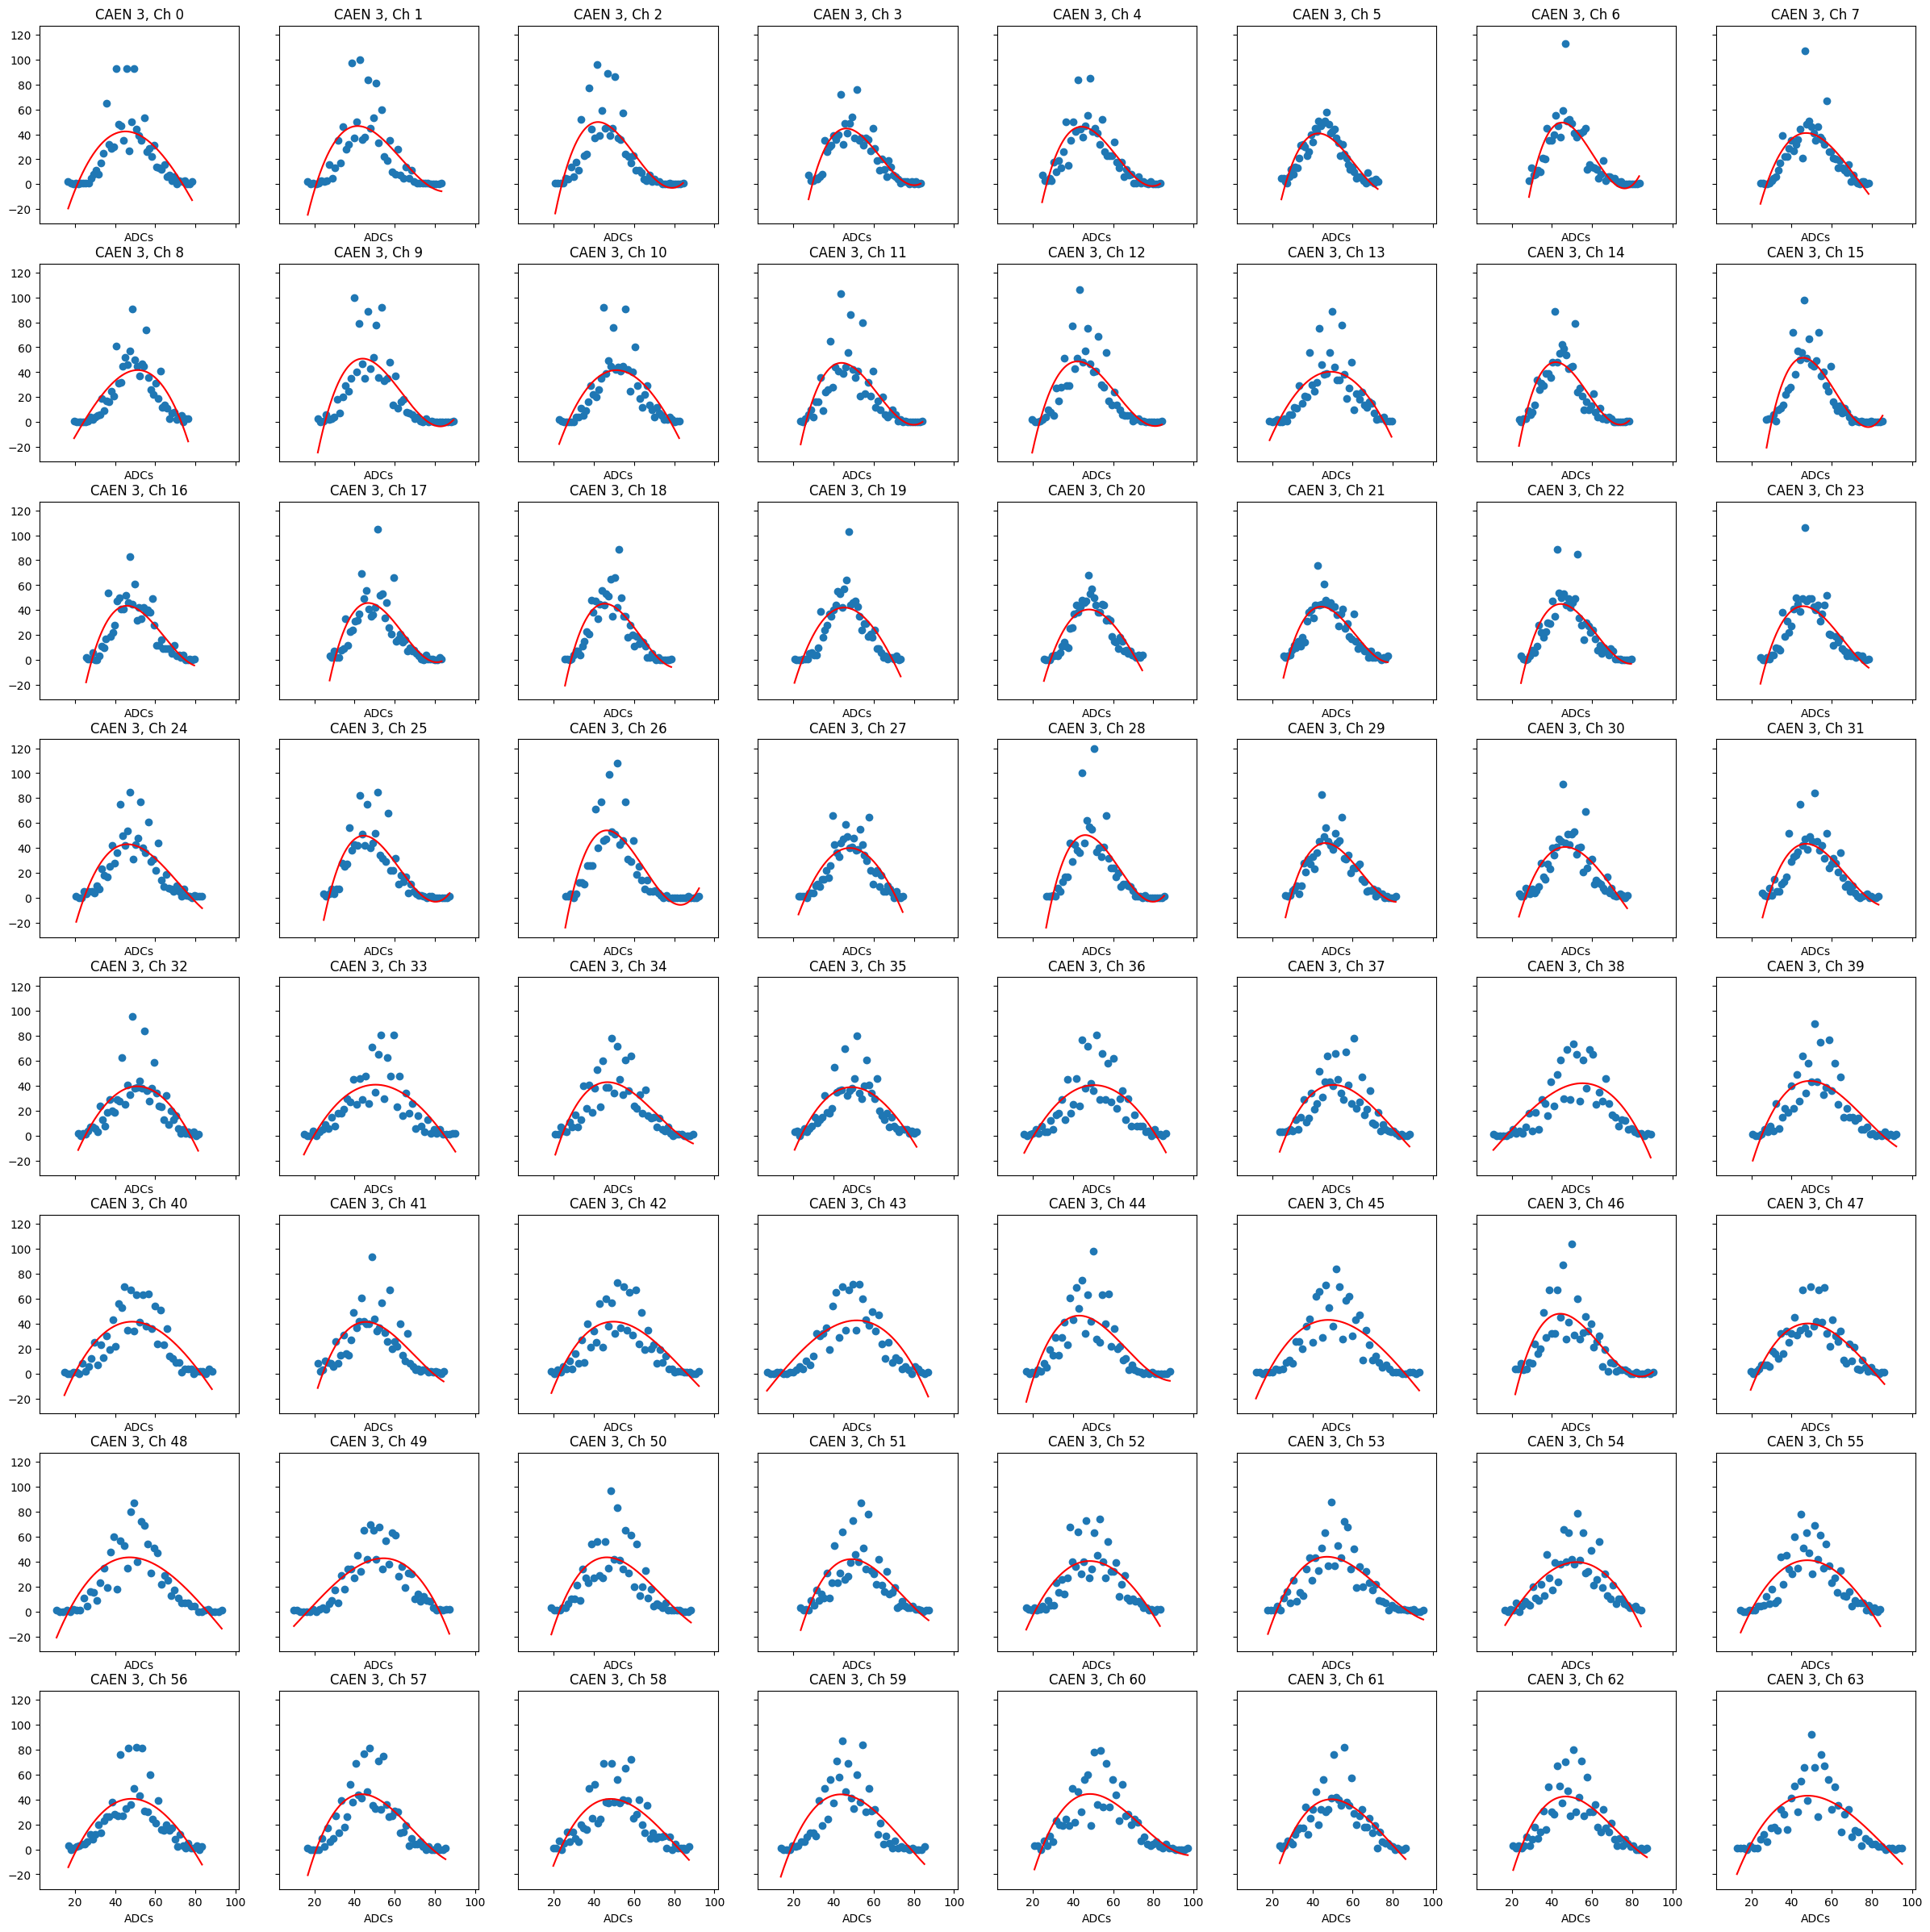

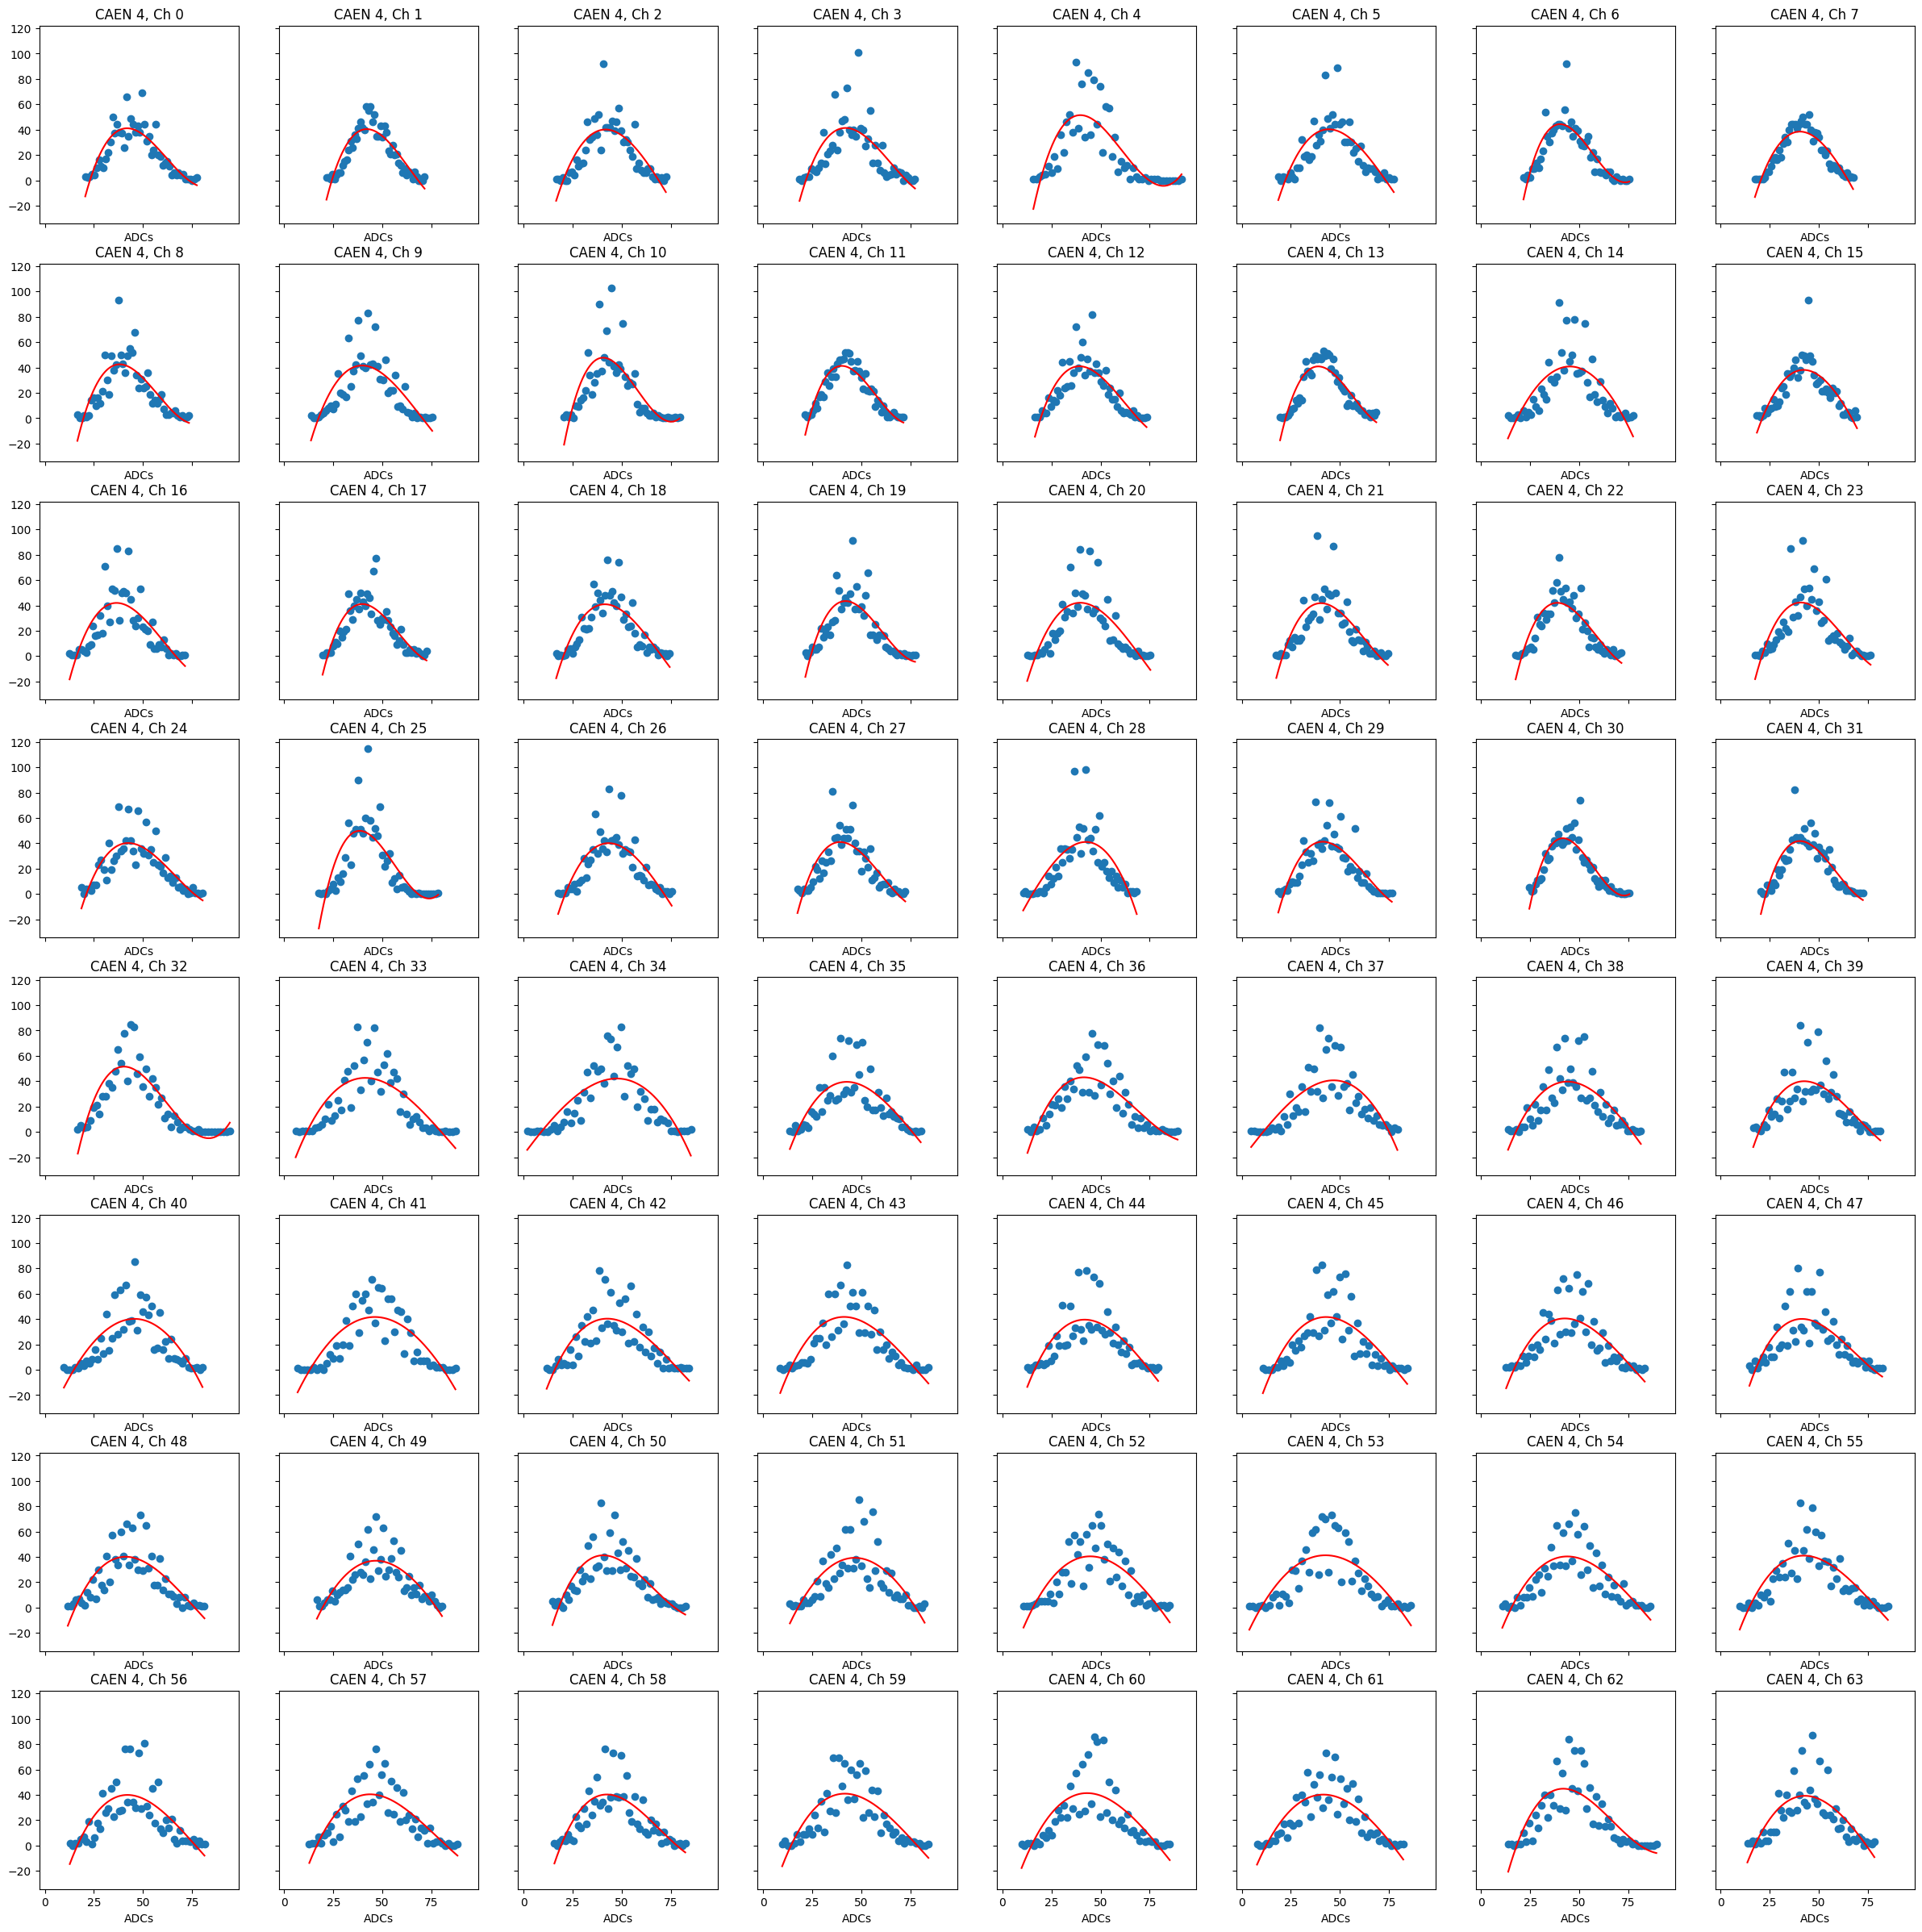

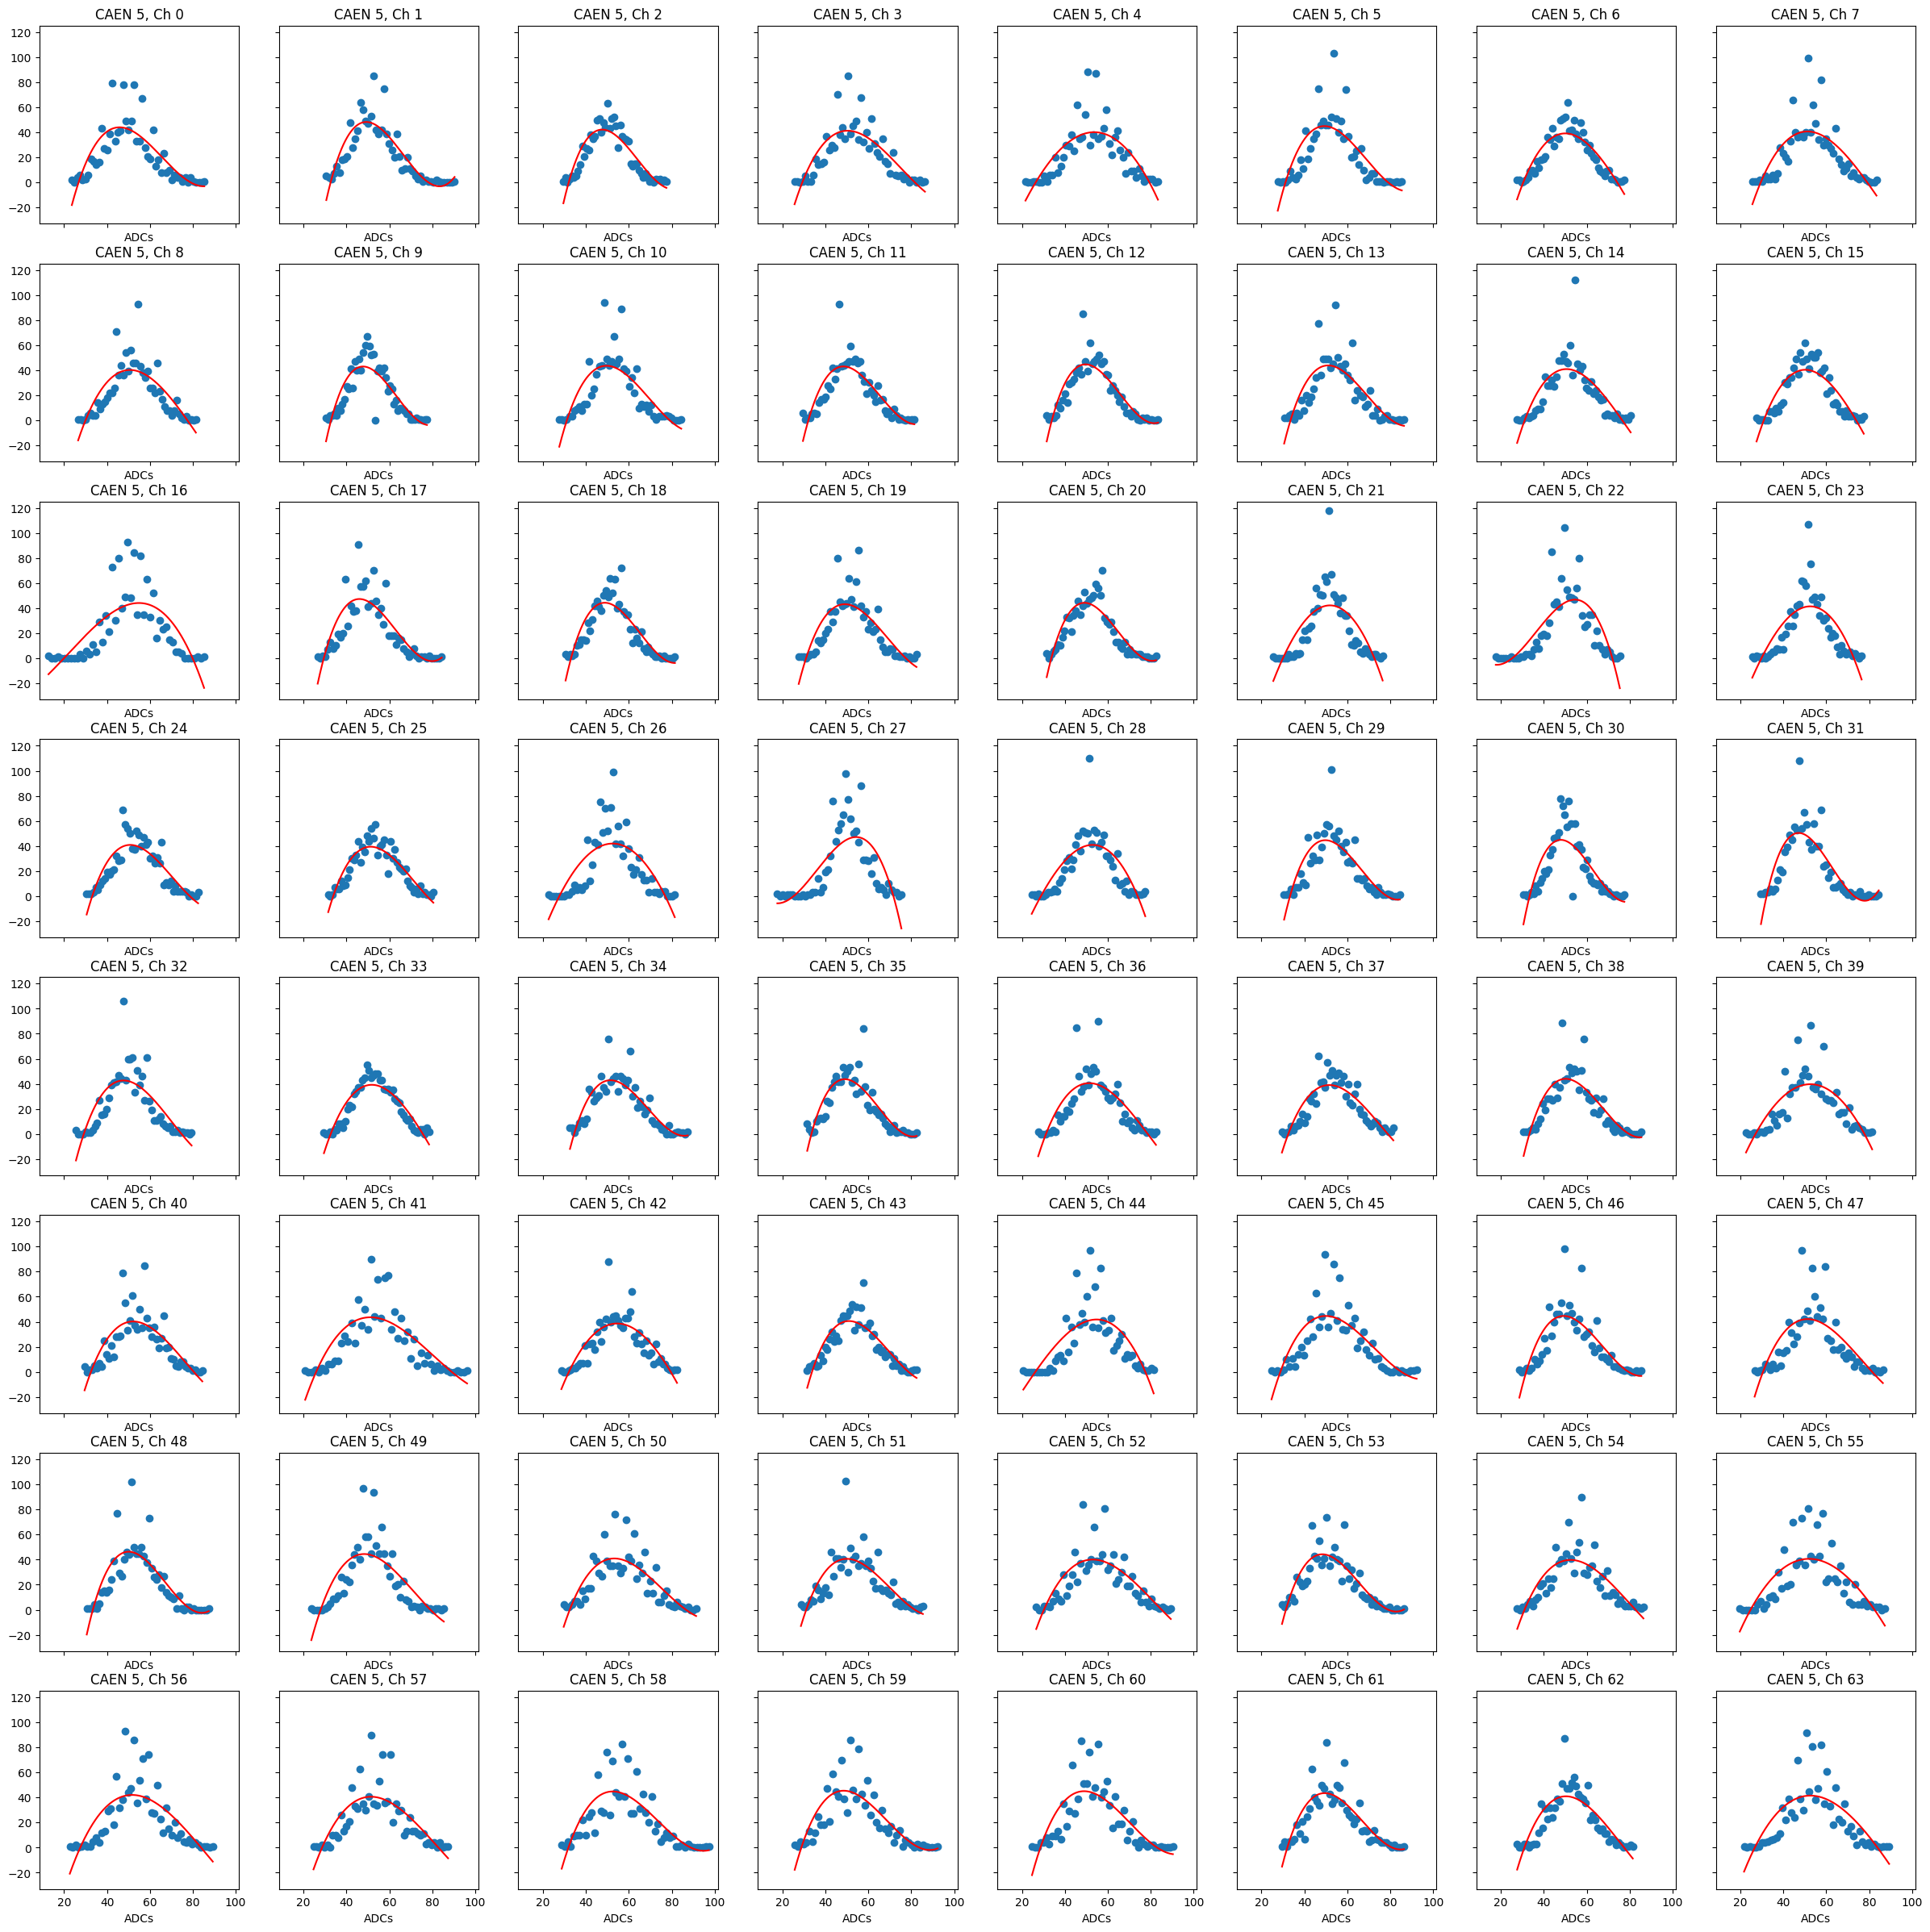

In [10]:
CAEN_MIP_dfs = []
for CAEN_unit in CAEN_numbers:
    CAEN_MIP_df = plot_CAEN_MIPs(MIP_df, pedestal_df, CAEN_unit, channel_numbers, gain_setting = "HG")
    CAEN_MIP_dfs.append(CAEN_MIP_df)

#### Combine the dataframes into one and then save it to a pickle file

In [11]:
all_CAEN_MIP_dfs = pd.concat(CAEN_MIP_dfs, axis=1)

In [12]:
all_CAEN_MIP_dfs

0-0  0-1  0-2  0-3  0-4  0-5  0-6  0-7  0-8  0-9  ...  5-54  5-55  5-56  \
HG    0    0    0    0    0    0    0    0    0    0  ...     0     0     0   

    5-57  5-58  5-59  5-60  5-61  5-62  5-63  
HG     0     0     0     0     0     0     0  

[1 rows x 384 columns]

In [13]:
output_pickle_name = "./MIP.pkl"
all_CAEN_MIP_dfs.to_pickle(output_pickle_name)  